<a href="https://colab.research.google.com/github/fongbubble/data_visulization_proj/blob/main/Supanu_DS_Final_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$\text{Supanu Tanatammatid 2546980}$$

ox24150@bristol.ac.uk\
random_state = 24150

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from yellowbrick.classifier import ClassPredictionError, ClassificationReport
from sklearn.model_selection import GridSearchCV


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load dataset
df = pd.read_csv('Cleaned_DelayedFlights_with_flags.csv')
df = df.drop(df.columns[0], axis =1)
# Data preprocessing
df.fillna(method='ffill', inplace=True)  # Example imputation
df.head()


<ipython-input-2-7507b6d14039>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Example imputation


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,SecurityDelay,LateAircraftDelay,ArrDelay_Flag,DepDelay_Flag,CarrierDelay_Flag,WeatherDelay_Flag,NASDelay_Flag,SecurityDelay_Flag,LateAircraftDelay_Flag,Date
0,2008,1,3,thu,20:03,19:55,22:11,22:25,WN,335,...,0.0,0.0,0,1,0,0,0,0,0,2008-01-03
1,2008,1,3,thu,07:54,07:35,10:02,10:00,WN,3231,...,0.0,0.0,1,1,0,0,0,0,0,2008-01-03
2,2008,1,3,thu,06:28,06:20,08:04,07:50,WN,448,...,0.0,0.0,1,1,0,0,0,0,0,2008-01-03
3,2008,1,3,thu,18:29,17:55,19:59,19:25,WN,3920,...,0.0,32.0,1,1,1,0,0,0,1,2008-01-03
4,2008,1,3,thu,19:40,19:15,21:21,21:10,WN,378,...,0.0,0.0,1,1,0,0,0,0,0,2008-01-03


In [ ]:
day_mapping = {'mon': 'Monday',
    'tue': 'Tuesday',
    'wed': 'Wednesday',
    'thu': 'Thursday',
    'fri': 'Friday',
    'sat': 'Saturday',
    'sun': 'Sunday'}
df['DayOfWeek'] = df['DayOfWeek'].map(day_mapping)

# Replace '24:00' with '00:00' before converting to datetime
df['DepTime'] = df['DepTime'].astype(str).str.replace('24:00', '00:00')
df['ArrTime'] = df['ArrTime'].astype(str).str.replace('24:00', '00:00')
df['CRSDepTime'] = df['CRSDepTime'].astype(str).str.replace('24:00', '00:00')
df['CRSArrTime'] = df['CRSArrTime'].astype(str).str.replace('24:00', '00:00')

# Create date and time columns
df['Dep_dt'] = pd.to_datetime(df['Date'] + ' ' + df['DepTime'], format='%Y-%m-%d %H:%M', errors='coerce')
df['CRSDep_dt'] = pd.to_datetime(df['Date'] + ' ' + df['CRSDepTime'], format='%Y-%m-%d %H:%M', errors='coerce')
df['Arr_dt'] = pd.to_datetime(df['Date'] + ' ' + df['ArrTime'], format='%Y-%m-%d %H:%M', errors='coerce')
df['CRSArr_dt'] = pd.to_datetime(df['Date'] + ' ' + df['CRSArrTime'], format='%Y-%m-%d %H:%M', errors='coerce')

df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'CRSArrTime', 'Date'], axis=1, inplace=True)

<ipython-input-4-9b0b610de158>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=popular_airports.index, y=popular_airports.values, palette=palette)


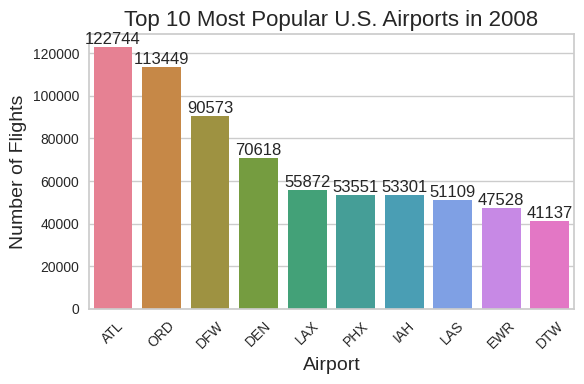

In [ ]:
popular_airports = df['Origin'].value_counts().head(10)
palette = sns.color_palette("husl", n_colors=len(popular_airports))

# Create a barplot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=popular_airports.index, y=popular_airports.values, palette=palette)
plt.title('Top 10 Most Popular U.S. Airports in 2008', fontsize=16)
plt.xlabel('Airport', fontsize=14)
plt.ylabel('Number of Flights', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-5-96d84f514e1f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airline_delay.index, y=top_airline_delay.values, palette=palette)


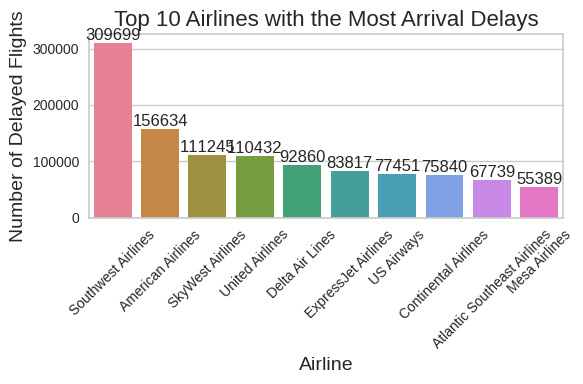

In [ ]:
df1 = df.copy()

carrier_code = {
    'WN': 'Southwest Airlines',
    'XE': 'ExpressJet Airlines',
    'YV': 'Mesa Airlines',
    'OH': 'Comair',
    'OO': 'SkyWest Airlines',
    'UA': 'United Airlines',
    'US': 'US Airways',
    'DL': 'Delta Air Lines',
    'EV': 'Atlantic Southeast Airlines',
    'F9': 'Frontier',
    'E9': 'Pinnacle Airlines',
    'AA': 'American Airlines',
    'AQ': 'Aloha',
    'AS': 'Alaska Airlines',
    'B6': 'JetBlue Airways',
    'CO': 'Continental Airlines'
}

df1['UniqueCarrier'] = df1['UniqueCarrier'].map(carrier_code)
df1['ArrDelay_Flag'] = df1['ArrDelay_Flag'] == 1
airline_delay = df1[df1['ArrDelay_Flag']].groupby('UniqueCarrier').size()
top_airline_delay = airline_delay.sort_values(ascending=False)[:10]

palette = sns.color_palette("husl", n_colors=len(popular_airports))
plt.figure(figsize=(6, 4))
sns.barplot(x=top_airline_delay.index, y=top_airline_delay.values, palette=palette)
plt.title('Top 10 Airlines with the Most Arrival Delays', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Number of Delayed Flights', fontsize=14)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df[['DayOfWeek', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancellationCode']] = df[['DayOfWeek', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancellationCode']].astype(str)
df[['DayOfWeek', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancellationCode']] = df[['DayOfWeek', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancellationCode']].apply(lambda col: LabelEncoder().fit_transform(col))

# Convert a datetime column to a timestamp as integer (in seconds since the epoch)
df['CRSDep_dt'] = pd.to_datetime(df['CRSDep_dt']).astype(int) // 10**9
df['Arr_dt'] = pd.to_datetime(df['Arr_dt']).astype(int) // 10**9
df['CRSArr_dt'] = pd.to_datetime(df['CRSArr_dt']).astype(int) // 10**9

In [ ]:
df2 = df.copy()
df2['Dep_dt'] = pd.to_datetime(df['Dep_dt']).astype(int) // 10**9
df3 = df.copy()
df3['Dep_dt'] = pd.to_datetime(df['Dep_dt']).astype(int) // 10**9
df.set_index('Dep_dt', inplace=True)

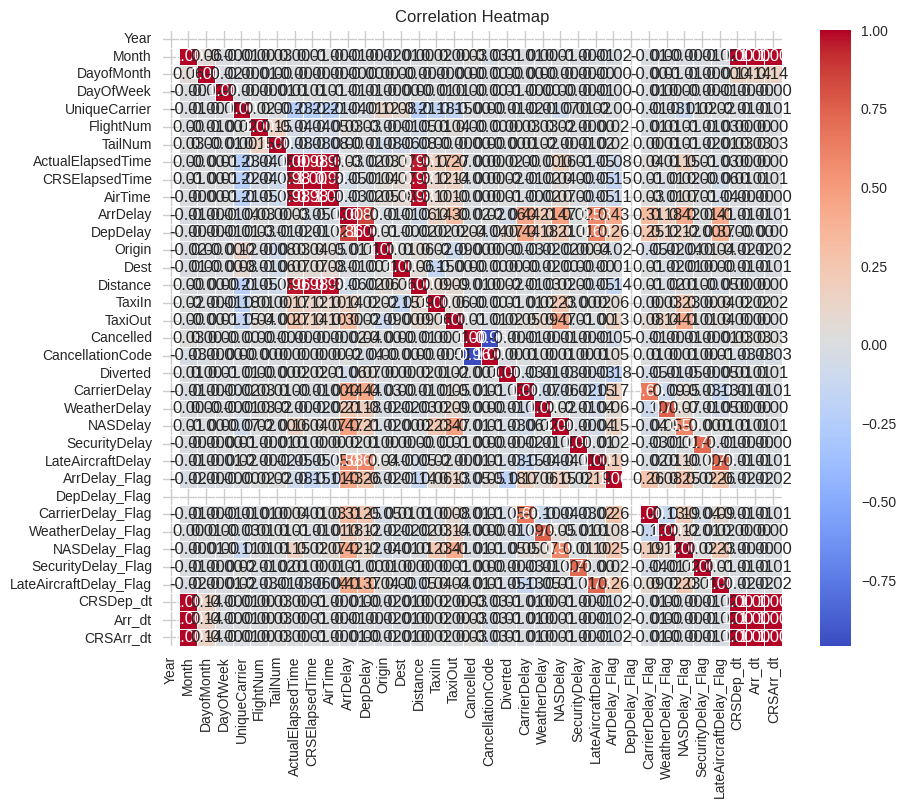

In [ ]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

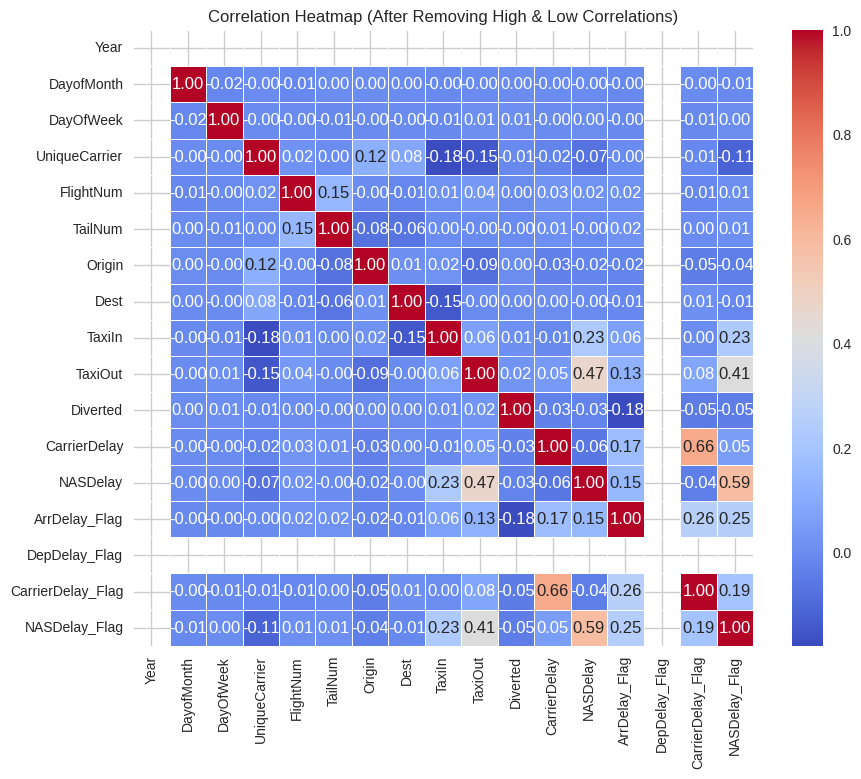

In [ ]:
corr_matrix = df.corr()
high_corr_var = np.where((corr_matrix > 0.7) | (corr_matrix < -0.7))

columns_to_remove = []
for i in range(len(high_corr_var[0])):
    if high_corr_var[0][i] != high_corr_var[1][i]:  # To avoid diagonal entries
        colname = corr_matrix.columns[high_corr_var[0][i]]
        columns_to_remove.append(colname)

columns_to_remove = list(set(columns_to_remove))
df = df.drop(columns=columns_to_remove)
corr_matrix_reduced = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_reduced, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap (After Removing High & Low Correlations)')
plt.show()

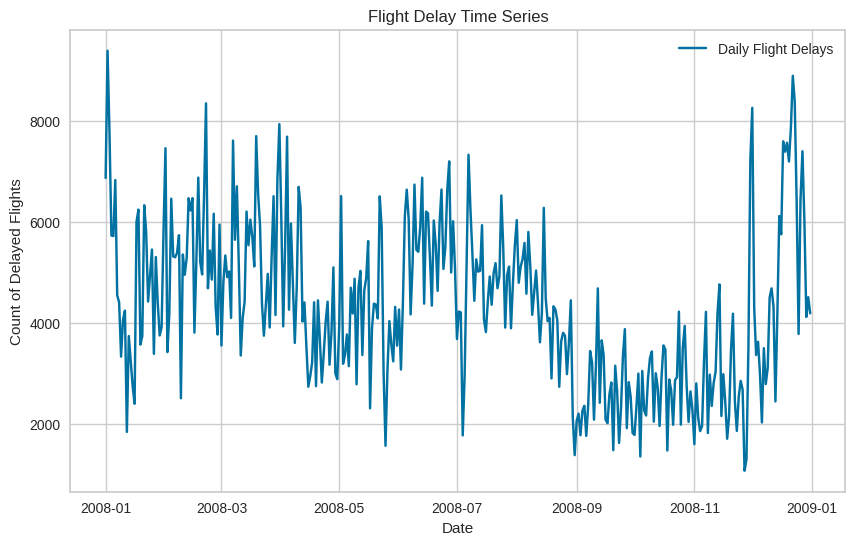

In [ ]:
daily_delays = df['ArrDelay_Flag'].resample('D').sum()  # 'D' sum daily resampling

# Plot the time series to understand the trends
plt.figure(figsize=(10, 6))
plt.plot(daily_delays, label='Daily Flight Delays')
plt.title('Flight Delay Time Series')
plt.xlabel('Date')
plt.ylabel('Count of Delayed Flights')
plt.legend()
plt.show()

In [ ]:
df_xgb = daily_delays.reset_index()
df_xgb['day_of_week'] = df_xgb['Dep_dt'].dt.dayofweek  # Extract day of week as a feature
df_xgb['lag_1'] = df_xgb['ArrDelay_Flag'].shift(1)  # Lag by 1 day
df_xgb['rolling_mean_7'] = df_xgb['ArrDelay_Flag'].rolling(window=7).mean()  # 7-day rolling average
df_xgb = df_xgb.dropna()  # Drop rows with missing values

X = df_xgb[['day_of_week', 'lag_1', 'rolling_mean_7']]
y = df_xgb['ArrDelay_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=24150)


#Models Comparison

In [ ]:
def arima_model(train, order=(5, 1, 0)):
    model = ARIMA(train, order=order)
    return model

def sarima_model(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    return model

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
models = {
    #'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    #'Lasso Regression': Lasso(random_state=24150),
    #'Ridge Regression': Ridge(random_state=24150),
    #'ElasticNet': ElasticNet(random_state=24150),
    #'Huber Regressor': HuberRegressor(),
    #'K-Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=24150),
    'Gradient Boosting': GradientBoostingRegressor(random_state=24150),
    #'Extra Trees': ExtraTreesRegressor(random_state=24150),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=24150),
    #'LightGBM': LGBMRegressor(random_state=24150),
    #'CatBoost': CatBoostRegressor(verbose=0, random_state=24150),
    #'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=300, random_state=24150),
    'Decision Tree': DecisionTreeRegressor(random_state=24150)
}

In [ ]:
time_series_models = {
    'LSTM': build_lstm_model,
    'ARIMA': arima_model,
    'SARIMA': sarima_model
}

In [ ]:
def evaluate_regressor(model, X_train, X_test, y_train, y_test, model_name=None):
    if model_name == 'LSTM':
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        lstm_model = model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
        lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = lstm_model.predict(X_test_reshaped)
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R²': r2_score(y_test, y_pred)
        }

    elif model_name in ['ARIMA', 'SARIMA']:
        model_fit = model(y_train).fit()
        y_pred = model_fit.forecast(steps=len(y_test))
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R²': r2_score(y_test, y_pred)
        }

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R²': r2_score(y_test, y_pred)
        }

    return metrics


In [ ]:
results = {}

for model_name, model in models.items():
    metrics = evaluate_regressor(model, X_train, X_test, y_train, y_test)
    results[model_name] = metrics

for model_name, model in time_series_models.items():
    metrics = evaluate_regressor(model, X_train, X_test, y_train, y_test, model_name=model_name)
    results[model_name] = metrics

results_df = pd.DataFrame(results).transpose()
print(results_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

                                 RMSE          MAE        R²
Support Vector Regressor  1986.383743  1676.324748 -0.031168
Random Forest             1354.993106   982.378750  0.520181
Gradient Boosting         1250.799517   915.859228  0.591136
XGBoost                   1334.352685   923.325058  0.534688
Decision Tree             1460.835377   995.138889  0.442293
LSTM                      4336.917555  3870.705642 -3.915476
ARIMA                     2344.590681  1626.227114 -0.436605
SARIMA                    2383.259892  1666.378475 -0.484383


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#XGBoost Regressor

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=24150)
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'learning_rate': [0.01, 0.1, 0.3],      # Learning rate
    'max_depth': [3, 5, 7],                 # Maximum depth of trees
    'min_child_weight': [1, 3, 5],          # Minimum sum of instance weight (Hessian)
    'gamma': [0, 0.1, 0.3],                 # Minimum loss reduction
    'subsample': [0.7, 0.8, 1.0],           # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],    # Fraction of features used per tree
    'reg_alpha': [0, 0.01, 0.1],            # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]               # L2 regularization term on weights
}

rmse_scorer = make_scorer(mean_squared_error, squared=False)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=50, scoring=rmse_scorer, cv=5, verbose=1, n_jobs=-1, random_state=24150)


random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE score: ", random_search.best_score_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Optimized XGBoost RMSE: {rmse}')
print(f'R-squared: {r2}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best RMSE score:  1275.7002282070778
Optimized XGBoost RMSE: 1377.6021982284299
R-squared: 0.5040351152420044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost RMSE: 1334.3526851926074
R-squared: 0.5346877574920654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


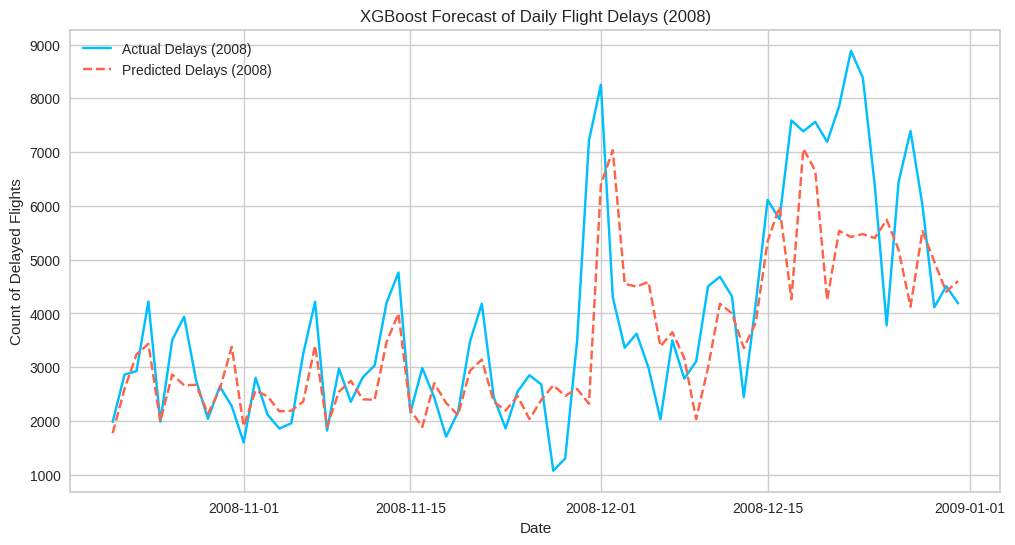

In [ ]:
test_dates = df_xgb.loc[y_test.index, 'Dep_dt']
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=24150)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'XGBoost RMSE: {rmse}')
print(f'R-squared: {r2}')
actual_vs_pred_df = pd.DataFrame({'Date': test_dates, 'Actual_Delays': y_test, 'Predicted_Delays': y_pred})

plt.figure(figsize=(12, 6))
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Actual_Delays'], label='Actual Delays (2008)', color='deepskyblue')
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Predicted_Delays'], label='Predicted Delays (2008)', linestyle='--', color='tomato')
plt.title('XGBoost Forecast of Daily Flight Delays (2008)')
plt.xlabel('Date')
plt.ylabel('Count of Delayed Flights')
plt.legend()
plt.grid(True)
plt.show()

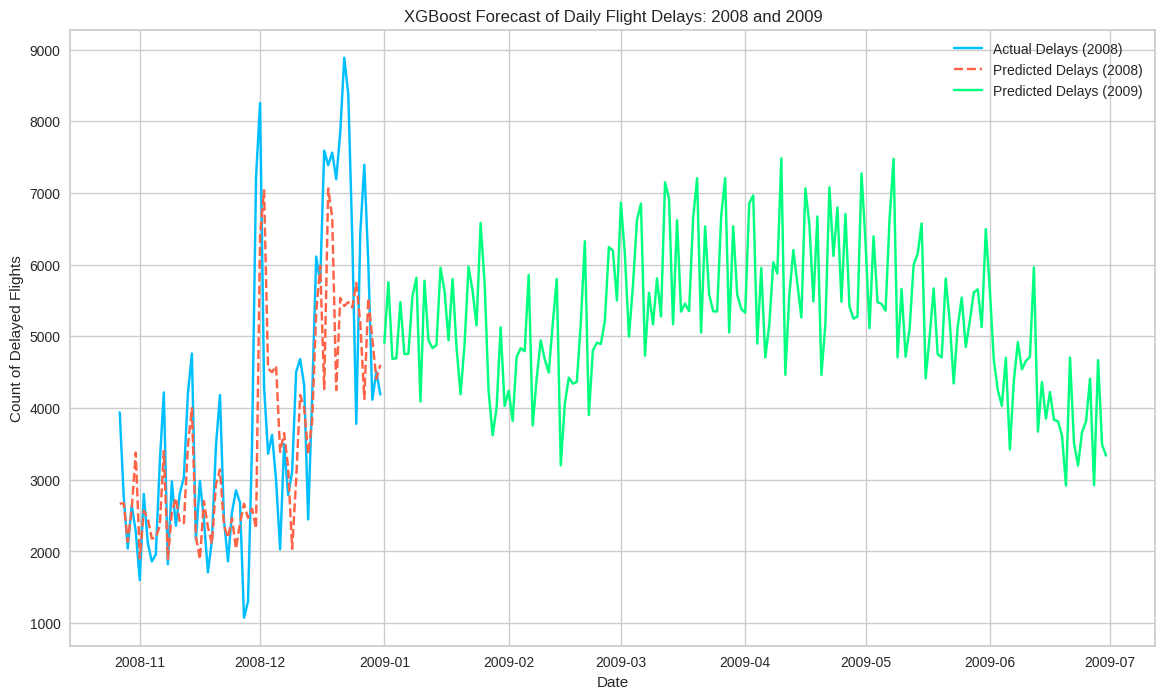

In [ ]:
test_indices = X_test.index
valid_test_indices = test_indices[test_indices < len(df_xgb)]
test_dates = df_xgb.iloc[valid_test_indices]['Dep_dt']
actual_vs_pred_df = pd.DataFrame({'Date': test_dates, 'Actual_Delays': y_test, 'Predicted_Delays': y_pred})
last_known = df_xgb.iloc[-1].copy()
dates_2009 = pd.date_range(start='2009-01-01', end='2009-06-30')
future_predictions = []

for date in dates_2009:
    day_of_week = date.dayofweek
    lag_1 = last_known['ArrDelay_Flag']
    recent_predictions = future_predictions[-7:] if len(future_predictions) >= 7 else [last_known['ArrDelay_Flag']] * (7 - len(future_predictions)) + future_predictions
    rolling_mean_7 = np.mean(recent_predictions)
    input_data = np.array([[day_of_week, lag_1, rolling_mean_7]])
    predicted_delay = model_xgb.predict(input_data)
    future_predictions.append(predicted_delay[0])
    last_known['ArrDelay_Flag'] = predicted_delay[0]

future_df = pd.DataFrame({'Date': dates_2009, 'Predicted_Delays': future_predictions})
combined_df = pd.concat([actual_vs_pred_df[['Date', 'Actual_Delays', 'Predicted_Delays']],
                         future_df[['Date', 'Predicted_Delays']]], ignore_index=True)


plt.figure(figsize=(14, 8))
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Actual_Delays'], label='Actual Delays (2008)', color='deepskyblue')
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Predicted_Delays'], label='Predicted Delays (2008)', linestyle='--', color='tomato')
plt.plot(future_df['Date'], future_df['Predicted_Delays'], label='Predicted Delays (2009)', color='springgreen')
plt.title('XGBoost Forecast of Daily Flight Delays: 2008 and 2009')
plt.xlabel('Date')
plt.ylabel('Count of Delayed Flights')
plt.legend()
plt.grid(True)
plt.show()

#Gradient Boosting Regressor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


GB RMSE: 1267.6352701494823
R-squared: 0.5800555401534472


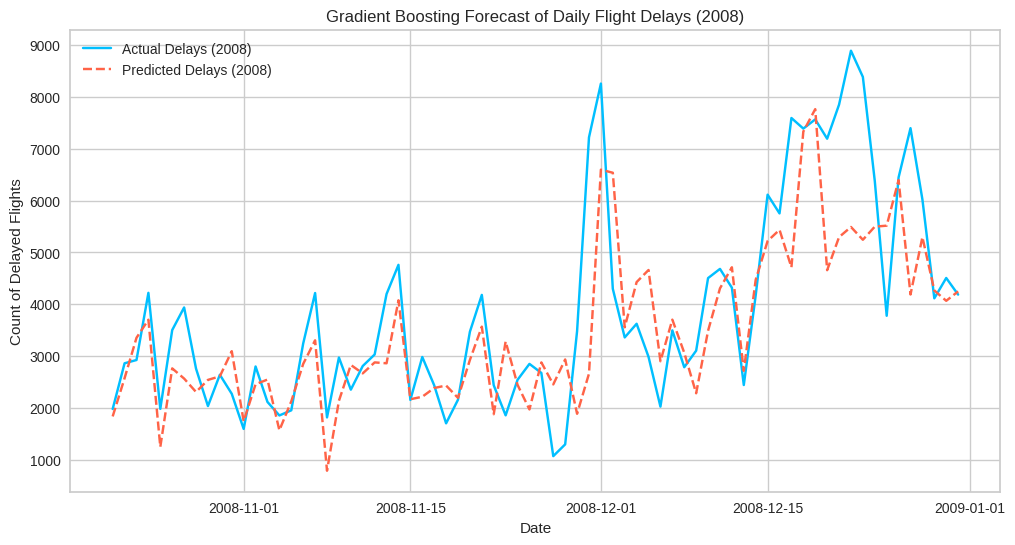

In [ ]:
df_xgb = daily_delays.reset_index()
df_xgb['day_of_week'] = df_xgb['Dep_dt'].dt.dayofweek
df_xgb['lag_1'] = df_xgb['ArrDelay_Flag'].shift(1)
df_xgb['rolling_mean_7'] = df_xgb['ArrDelay_Flag'].rolling(window=7).mean()
df_xgb = df_xgb.dropna()

X = df_xgb[['day_of_week', 'lag_1', 'rolling_mean_7']]
y = df_xgb['ArrDelay_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=24150)


test_dates = df_xgb.loc[y_test.index, 'Dep_dt']
model_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.5, max_depth=2, min_samples_leaf=4, max_features='log2', random_state=24150)
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'GB RMSE: {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual Delays (2008)', color='deepskyblue')
plt.plot(test_dates, y_pred, label='Predicted Delays (2008)', linestyle='--', color='tomato')
plt.title('Gradient Boosting Forecast of Daily Flight Delays (2008)')
plt.xlabel('Date')
plt.ylabel('Count of Delayed Flights')
plt.legend()
plt.grid(True)
plt.show()

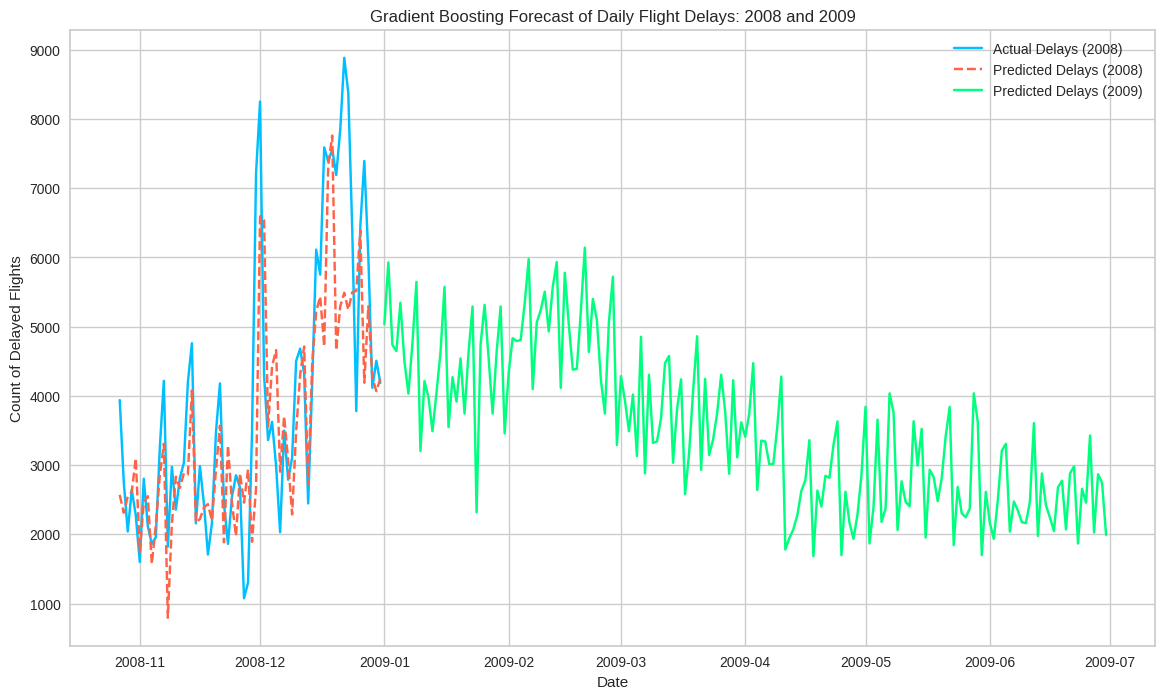

In [ ]:
test_indices = X_test.index
valid_test_indices = test_indices[test_indices < len(df_xgb)]
test_dates = df_xgb.iloc[valid_test_indices]['Dep_dt']
actual_vs_pred_df = pd.DataFrame({'Date': test_dates, 'Actual_Delays': y_test, 'Predicted_Delays': y_pred})

last_known = df_xgb.iloc[-1].copy()
dates_2009 = pd.date_range(start='2009-01-01', end='2009-06-30')
future_predictions = []

for date in dates_2009:
    day_of_week = date.dayofweek
    lag_1 = last_known['ArrDelay_Flag']
    recent_predictions = future_predictions[-7:] if len(future_predictions) >= 7 else [last_known['ArrDelay_Flag']] * (7 - len(future_predictions)) + future_predictions
    rolling_mean_7 = np.mean(recent_predictions)
    input_data = pd.DataFrame([[day_of_week, lag_1, rolling_mean_7]], columns=X.columns)
    input_data = input_data.fillna(0)
    predicted_delay = model_gb.predict(input_data)
    future_predictions.append(predicted_delay[0])
    last_known['ArrDelay_Flag'] = predicted_delay[0]

future_df = pd.DataFrame({'Date': dates_2009, 'Predicted_Delays': future_predictions})
combined_df = pd.concat([actual_vs_pred_df[['Date', 'Actual_Delays', 'Predicted_Delays']],
                         future_df[['Date', 'Predicted_Delays']]], ignore_index=True)

plt.figure(figsize=(14, 8))
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Actual_Delays'], label='Actual Delays (2008)', color='deepskyblue')
plt.plot(actual_vs_pred_df['Date'], actual_vs_pred_df['Predicted_Delays'], label='Predicted Delays (2008)', linestyle='--', color='tomato')
plt.plot(future_df['Date'], future_df['Predicted_Delays'], label='Predicted Delays (2009)', color='springgreen')
plt.title('Gradient Boosting Forecast of Daily Flight Delays: 2008 and 2009')
plt.xlabel('Date')
plt.ylabel('Count of Delayed Flights')
plt.legend()
plt.grid(True)
plt.show()

#Random Under Sampler (Imbalance)

In [ ]:
df2 = df2.drop('ArrDelay', axis=1)
X = df2.drop('ArrDelay_Flag', axis=1)
y = df2['ArrDelay_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24150)

<ipython-input-23-7d5ba4a612bc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train, palette='Set2')


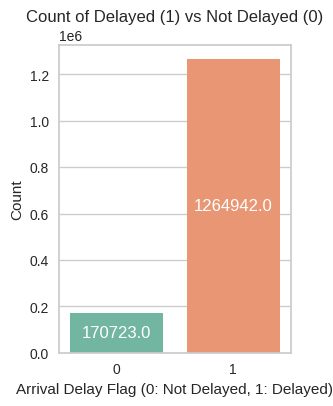

In [ ]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(x=y_train, palette='Set2')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', color='white', fontsize=12)

plt.title('Count of Delayed (1) vs Not Delayed (0)')
plt.xlabel('Arrival Delay Flag (0: Not Delayed, 1: Delayed)')
plt.ylabel('Count')
plt.show()

<ipython-input-24-d10725e09fb8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_resampled, palette='Set2')


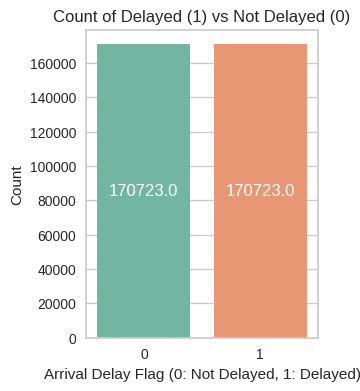

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=24150)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

plt.figure(figsize=(3, 4))
ax = sns.countplot(x=y_train_resampled, palette='Set2')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', color='white', fontsize=12)
plt.title('Count of Delayed (1) vs Not Delayed (0)')
plt.xlabel('Arrival Delay Flag (0: Not Delayed, 1: Delayed)')
plt.ylabel('Count')
plt.show()


# XGBoostClassifier (Feature Selection)

<ipython-input-25-e73e1eb705ba>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_features, palette="husl")


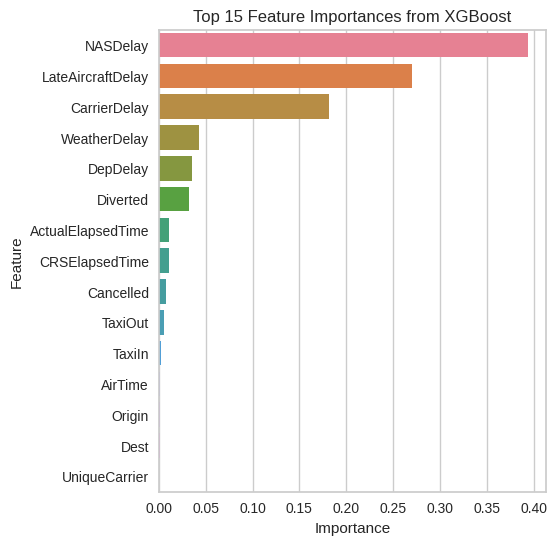

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=24150
)

xgb_classifier.fit(X_train_resampled, y_train_resampled)
importances = xgb_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
n = 15
top_n_features = feature_importance_df['feature'].head(n).tolist()

top_features = feature_importance_df.head(n)

plt.figure(figsize=(5, 6))
sns.barplot(x="importance", y="feature", data=top_features, palette="husl")
plt.title(f"Top {n} Feature Importances from XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

X_train_top_n = X_train_resampled[top_n_features]
X_test_top_n = X_test[top_n_features]

#Standard Scaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top_n)
X_test_scaled = scaler.transform(X_test_top_n)

#Models Comparison

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=24150),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=24150),
    #'Support Vector Classifier': SVC(probability=True, random_state=24150),
    'XGBoost': XGBClassifier(random_state=24150),
    #'Neural Network': MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=24150),
    #'LightGBM': LGBMClassifier(random_state=24150),
    #'CatBoost': CatBoostClassifier(verbose=0, random_state=24150),
    'Gradient Boosting': GradientBoostingClassifier(random_state=24150),
    #'K-Nearest Neighbors': KNeighborsClassifier(),
    #'AdaBoost': AdaBoostClassifier(random_state=24150),
    #'Naive Bayes': GaussianNB(),
    #'Extra Trees': ExtraTreesClassifier(random_state=24150),
    'Decision Tree': DecisionTreeClassifier(random_state=24150)
}

In [ ]:
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train_resampled, y_test):
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A',
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }
    return metrics

results = {}

for model_name, model in models.items():
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_resampled, y_test)
    results[model_name] = metrics


results_df = pd.DataFrame(results).transpose()
print(results_df)

                     Accuracy  F1-Score   ROC-AUC  Precision    Recall
Logistic Regression  0.981230  0.989236  0.999920   0.999987  0.978714
Random Forest        0.934157  0.961209  0.995968   0.999611  0.925648
XGBoost              0.967803  0.981397  0.998979   0.999787  0.963671
Gradient Boosting    0.850762  0.907715  0.962893   0.997410  0.832821
Decision Tree        0.981411  0.989366  0.982092   0.997669  0.981199


#Decision Tree Classfier

In [ ]:
decision_tree = DecisionTreeClassifier(criterion='gini', random_state=24150)
decision_tree.fit(X_train_scaled, y_train_resampled)

y_pred = decision_tree.predict(X_test_scaled)

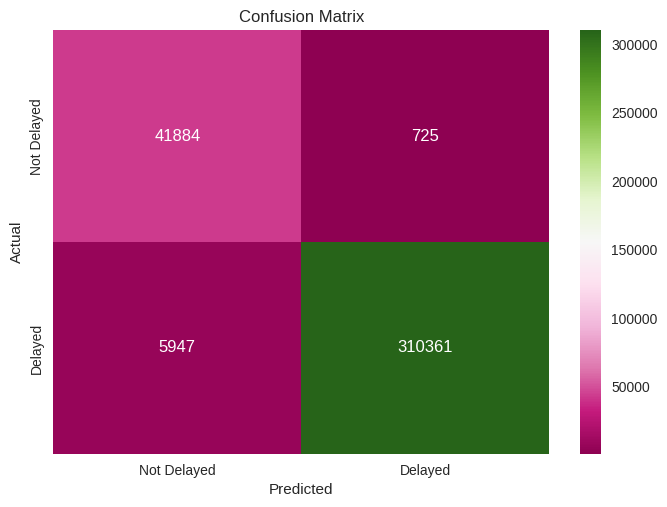


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     42609
           1       1.00      0.98      0.99    316308

    accuracy                           0.98    358917
   macro avg       0.94      0.98      0.96    358917
weighted avg       0.98      0.98      0.98    358917

Accuracy: 0.9814
RMSE: 0.1363

ROC-AUC Score: 0.9821
Precision: 0.9976694547488476
Recall: 0.9811987050596255


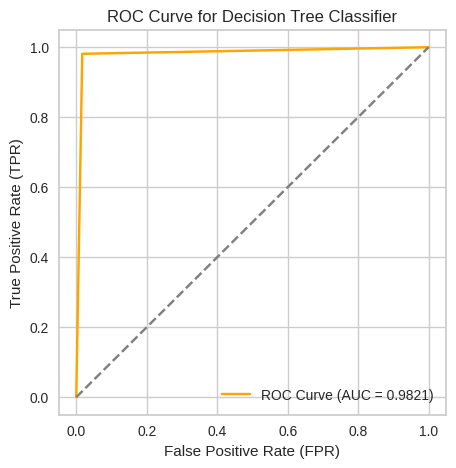

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
y_pred_proba = decision_tree.predict_proba(X_test_scaled)[:, 1]
rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
print(f"RMSE: {rmse:.4f}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
precision = precision_score(y_test, y_pred.round())
recall = recall_score(y_test, y_pred.round())
print(f'Precision: {precision}')
print(f'Recall: {recall}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve for Decision Tree Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


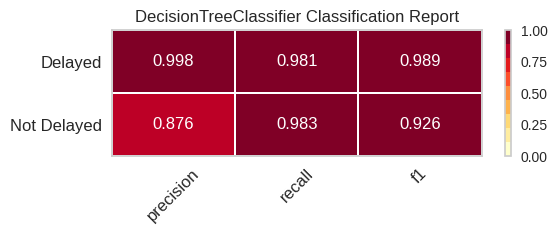

In [ ]:
classes = ['Not Delayed', 'Delayed']
report = ClassificationReport(decision_tree, size=(600, 250), classes=classes)
report.score(X_test_scaled, y_test)
c = report.poof()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


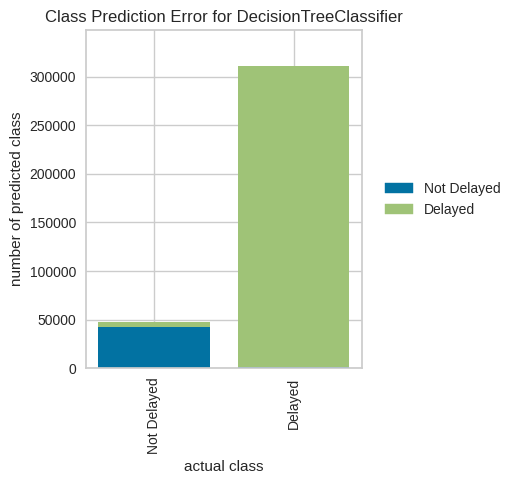

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
error = ClassPredictionError(decision_tree, classes=classes, size=(600, 500))
error.score(X_test_scaled, y_test)
error.poof()
